In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from tensorflow.keras import layers
from IPython import display
from sklearn import preprocessing

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.set_soft_device_placement(True)

Num GPUs Available:  1


In [3]:
def plt_tracks(tracks):
    if tracks.ndim != 3:
        print('Incorrect tracks dimension')
    else:
        for i in range(len(tracks)):
            track_show(tracks[i])
        plt.colorbar().set_label('Time')

def track_show(track):
    X = track[:, 0]
    Y = track[:, 1]
    plt.plot(X[:], Y[:], '-')
    plt.scatter(X[:], Y[:], c=np.arange(len(X)), s = 2)
    plt.xlabel('X'); plt.ylabel('Y')


In [2]:
def plt_tracks(tracks):
    if tracks.ndim != 3:
        print('Incorrect tracks dimension')
    else:
        for i in range(len(tracks)):
            track_show(tracks[i])
        plt.colorbar().set_label('Time')

def track_show(track):
    X = track[:, 0]
    Y = track[:, 1]
    plt.plot(X[:], Y[:], '-')
    plt.scatter(X[:], Y[:], c=np.arange(len(X)), s = 2)
    plt.xlabel('X'); plt.ylabel('Y')


swimmers = pd.read_csv('./dataset/swimmers1um.csv')
#swimmers2 = pd.read_csv('swimmers2um.csv')
#swimmers5 = pd.read_csv('swimmers5um.csv')

col = swimmers.iloc[0, :].size
row = swimmers.iloc[:, 0].size
print('columns: %d \nrows: %d' %(col, row))

list_dataset = []

for i in range(1, int((col+1)/2)):
    X = [] # clear X
    X.append(preprocessing.minmax_scale(swimmers.iloc[:, i*2-1]))# X
    X.append(preprocessing.minmax_scale(swimmers.iloc[:, i*2]))# Y
    list_dataset.append(np.array(X).T)

train_dataset = np.array(list_dataset).reshape(5, 999, 2)

plt_tracks(msd(train_dataset))

columns: 11 
rows: 999


NameError: name 'msd' is not defined

In [41]:
andi_train_x = np.load('./dataset/andi_train_x.npy')
andi_train_y = np.load('./dataset/andi_train_y.npy')

In [42]:
CLASS = 0
classes = [[] for i in range(5)]
for i in range(5):
    classes[i].append(np.argwhere(andi_train_y == i).reshape(-1))
train_dataset = andi_train_x[classes[CLASS]]
for i in range(len(train_dataset)):
    train_dataset[i] = preprocessing.minmax_scale(train_dataset[i])
plt_tracks(train_dataset)

<ipython-input-42-e039fa0d1e5f>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_dataset = andi_train_x[classes[CLASS]]


AttributeError: 'numpy.ndarray' object has no attribute 'track_show'

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(111*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((111, 256)))
    assert model.output_shape == (None, 111, 256)  # Note: None is the batch size
    
    model.add(layers.Conv1DTranspose(128, 8, strides=1, padding='same', use_bias=False, ))
    assert model.output_shape == (None, 111, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(64, 8, strides=3, padding='same', use_bias=False))
    assert model.output_shape == (None, 333, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(2, 4, strides=3, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 999, 2)

    return model

In [34]:
generator = make_generator_model()

noise = tf.random.uniform([1,100], minval=0, maxval=1)
generated_image = generator(noise, training=False)

def msd(tracks):
    ts = []
    for track in tracks:
        t = []
        for i in range(1, len(track)):
            dx = abs(track[i][0] - track[0][0])
            dy = abs(track[i][1] - track[0][1])
            t.append([dx, dy])
        ts.append(t)
    return tf.convert_to_tensor(ts)

msd(generated_image)

<tf.Tensor: shape=(1, 998, 2), dtype=float32, numpy=
array([[[0.00099429, 0.00604405],
        [0.00263282, 0.00591558],
        [0.01066013, 0.00744173],
        ...,
        [0.01088634, 0.01419105],
        [0.00264978, 0.00064156],
        [0.00715452, 0.01939123]]], dtype=float32)>

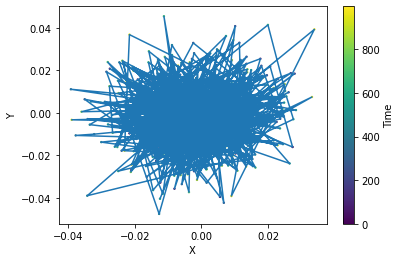

In [75]:
plt_tracks(generator(tf.random.uniform([1,100], minval=0, maxval=1), training = False))

In [71]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, 3, dilation_rate=2, padding='same',
                                     input_shape=[998, 2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 3, dilation_rate=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.GaussianNoise(0.1))
    model.add(layers.Dense(1))

    return model

In [82]:
discriminator = make_discriminator_model()
decision = discriminator(msd(generated_image), training = True)
print (decision)

tf.Tensor([[0.19152895]], shape=(1, 1), dtype=float32)


In [61]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [40]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(msd(images), training=True)
      fake_output = discriminator(msd(generated_images), training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [41]:
def train(dataset, epochs):
  start = time.time()
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,
    #                        epoch + 1,
    #                         seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)
    if (epoch+1) % 50 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [42]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      taj1_X = predictions[i, :, 0]
      taj1_Y = predictions[i, :, 1]
      plt.plot(taj1_X[:], taj1_Y[:], '-')
      plt.scatter(taj1_X[:],taj1_Y[:], c=np.arange(999), s = 2)
      plt.xlabel('X'); plt.ylabel('Y')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [43]:
BATCH_SIZE = 2
BUFFER_SIZE = 4
train_X = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [44]:
train(train_X,  EPOCHS)

TypeError: in user code:

    <ipython-input-40-e995836e84b9>:10 train_step  *
        real_output = discriminator(msd(images), training=True)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py:985 __call__  **
        inputs = tf.nest.map_structure(_convert_numpy_or_python_types, inputs)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\nest.py:869 map_structure
        structure[0], [func(*x) for x in entries],
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\nest.py:869 <listcomp>
        structure[0], [func(*x) for x in entries],
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py:3299 _convert_numpy_or_python_types
        return tf.convert_to_tensor(x)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\ops.py:1430 convert_to_tensor_v2_with_dispatch
        return convert_to_tensor_v2(
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\ops.py:1436 convert_to_tensor_v2
        return convert_to_tensor(
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\profiler\trace.py:163 wrapped
        return func(*args, **kwargs)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\tensor_conversion_registry.py:52 _default_conversion_function
        return constant_op.constant(value, dtype, name=name)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\constant_op.py:271 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\constant_op.py:288 _constant_impl
        tensor_util.make_tensor_proto(
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\tensor_util.py:564 make_tensor_proto
        append_fn(tensor_proto, proto_values)
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\tensor_util.py:156 SlowAppendObjectArrayToTensorProto
        tensor_proto.string_val.extend([compat.as_bytes(x) for x in proto_values])
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\tensor_util.py:156 <listcomp>
        tensor_proto.string_val.extend([compat.as_bytes(x) for x in proto_values])
    c:\users\15051\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\compat.py:86 as_bytes
        raise TypeError('Expected binary or unicode string, got %r' %

    TypeError: Expected binary or unicode string, got <tf.Tensor 'while/Abs:0' shape=() dtype=float64>


Save model

In [ ]:
generator.save_weights('./checkpoints/1um_checkpoint')

In [ ]:
generator = make_generator_model()
generator.load_weights('./checkpoints/2um_checkpoint')

In [ ]:
predictions = generator(tf.random.normal([10000, noise_dim]), training=False)

In [ ]:
arr_predictions = np.array(predictions)
np.save('./dataset/tracks_2uml', arr_predictions)

In [ ]:
x1 = np.load('./dataset/tracks_1um.npy')
x2 = np.load('./dataset/tracks_2um.npy')
x3 = np.load('./dataset/tracks_5um.npy')
test = np.concatenate((x1, x2, x3), axis=0)
np.save('tracks_val.npy', test)

In [ ]:
labels1 = np.zeros(10000)
labels2 = np.zeros(10000)+1
labels3 = np.zeros(10000)+2
labels = np.concatenate((labels1, labels2, labels3))

In [ ]:
labels[10000:20000]

In [ ]:
np.save('labels.npy', labels)

In [ ]:
i = 
taj1_X = predictions[i, :, 0]
taj1_Y = predictions[i, :, 1]
#print(predictions[i,:,:,0])
plt.plot(taj1_X[:], taj1_Y[:], '-')
plt.scatter(taj1_X[:],taj1_Y[:], c=np.arange(999), s = 5)
plt.colorbar().set_label('Time')
plt.xlabel('X'); plt.ylabel('Y') 